## Project: **Système Intelligent de Gestion et d'Analyse de Mots de Passe**

#### Initialisation

In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import spacy, joblib

path = "C:\\Users\\User\\PycharmProjects\\PassPy\\training\\"

### Phase 1: Recherche et préparation des données

#### 1.1.  Tri et Nettoyage

In [6]:
# We load the password data here from the passdb.txt file using utf-8 vs latin-1
passwords = pd.read_csv(str(path + 'passdb.txt'), names=['password'], encoding='latin-1', lineterminator='\n', delimiter='\rt')

# we then check for duplictes pass and get rid of them
print("before :", len(passwords))
passwords.drop_duplicates(inplace=True)     # we get rid of duplicates ones

# after the clean
print(f"And now : {len(passwords)}")

# we format the modification into a csv file
passwords.to_csv(str(path + 'cleaned_passdb.csv'), index=False)

C:\Users\User\AppData\Local\Temp\ipykernel_19872\2480676456.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  passwords = pd.read_csv(str(path + 'passdb.txt'), names=['password'], encoding='latin-1', lineterminator='\n', delimiter='\rt')


before : 1098498
And now : 1095268


#### 1.2. Classification (weak, medium, weak)

In [10]:
# we read from the new file ( which represents our database)
passwords = pd.read_csv(path + 'cleaned_passdb.csv', names=['password'])

# here we define the data_categ function to assign a category to a password
def data_categ(password):
    # Check the length of the password
    password = str(password)
    length = len(password)

    # Define regex patterns for different character types
    has_lower = re.search(r'[a-z]', password)  # At least one lowercase letter
    has_upper = re.search(r'[A-Z]', password)  # At least one uppercase letter
    has_digit = re.search(r'\d', password)  # At least one digit
    has_special = re.search(r'[@$!%*?&]', password)  # At least one special character

    # Classify based on criteria
    if length < 6:
        return 'weak'
    elif 6 <= length <= 10:
        if has_lower and has_upper and (has_digit or has_special):
            return 'medium'
        else:
            return 'weak'
    elif length > 10:
        if has_lower and has_upper and has_digit and has_special:
            return 'strong'
        else:
            return 'medium'


# here we assign the categ by a creating a new field or a column in the dataframe
passwords['strength'] = passwords['password'].apply(data_categ)

# we save the password in a new csv file
passwords.to_csv(str(path + 'categ_passdb.csv'), index=False)

### Phase 2: Analyse de la Force des mots de passe

#### 2.1. Feature Extraction 
(length, uppercase, lowercase, digits, special_chars, sequential, entropy)

In [4]:
# We load our data back here
passwords = pd.read_csv(path + 'categ_passdb.csv')
# we set the type of password'field before processing them
passwords['password'] = passwords['password'].astype(str)

# Feature extraction functions
def count_uppercase(password):
    return sum(1 for c in password if c.isupper())

def count_lowercase(password):
    return sum(1 for c in password if c.islower())

def count_digits(password):
    return sum(1 for c in password if c.isdigit())

def count_special_chars(password):
    return sum(1 for c in password if not c.isalnum())

def has_sequential_chars(password):
    # Check for sequences of 3 or more characters
    sequential = False
    for i in range(len(password) - 2):
        substr = password[i:i+3]
        if substr.isalpha() or substr.isdigit():
            if ord(substr[1]) == ord(substr[0]) + 1 and ord(substr[2]) == ord(substr[1]) + 1:
                sequential = True
                break
    return int(sequential)

def calculate_entropy(password):
    # Calculate Shannon entropy
    entropy = 0
    length = len(password)
    if length == 0:
        return 0
    chars = set(password)
    for c in chars:
        p = password.count(c) / length
        entropy -= p * np.log2(p)
    return entropy

# Apply feature extraction
passwords['length'] = passwords['password'].apply(len)
passwords['uppercase'] = passwords['password'].apply(count_uppercase)
passwords['lowercase'] = passwords['password'].apply(count_lowercase)
passwords['digits'] = passwords['password'].apply(count_digits)
passwords['special_chars'] = passwords['password'].apply(count_special_chars)
passwords['sequential'] = passwords['password'].apply(has_sequential_chars)
passwords['entropy'] = passwords['password'].apply(calculate_entropy)

In [4]:
passwords

,password,strength,length,uppercase,lowercase,digits,special_chars,sequential,entropy
0,password,weak,8,0,8,0,0,0,2.750000
1,123456,weak,6,0,0,6,0,1,2.584963
2,password,weak,8,0,8,0,0,0,2.750000
3,12345678,weak,8,0,0,8,0,1,3.000000
4,qwerty,weak,6,0,6,0,0,0,2.584963
...,...,...,...,...,...,...,...,...,...
1095264,zZq4LUdasPDE,medium,12,6,5,1,0,0,3.584963
1095265,zzs0702,weak,7,0,3,4,0,0,2.235926
1095266,zzU@Qzo,medium,7,2,4,0,1,0,2.128085
1095267,zZXB93yg8pc,medium,11,3,5,3,0,0,3.459432


#### 2.2. Encode and Split the data for training and test 

In [5]:
# Encode target labels
label_encoder = LabelEncoder()
passwords['strength_encoded'] = label_encoder.fit_transform(passwords['strength'])  # 'weak', 'medium', 'strong'

# Select feature columns
feature_cols = ['length', 'uppercase', 'lowercase', 'digits', 'special_chars', 'sequential', 'entropy']
X = passwords[feature_cols]
y = passwords['strength_encoded']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [8]:
passwords

,password,strength,length,uppercase,lowercase,digits,special_chars,sequential,entropy,strength_encoded
0,password,weak,8,0,8,0,0,0,2.750000,2
1,123456,weak,6,0,0,6,0,1,2.584963,2
2,password,weak,8,0,8,0,0,0,2.750000,2
3,12345678,weak,8,0,0,8,0,1,3.000000,2
4,qwerty,weak,6,0,6,0,0,0,2.584963,2
...,...,...,...,...,...,...,...,...,...,...
1095264,zZq4LUdasPDE,medium,12,6,5,1,0,0,3.584963,0
1095265,zzs0702,weak,7,0,3,4,0,0,2.235926,2
1095266,zzU@Qzo,medium,7,2,4,0,1,0,2.128085,0
1095267,zZXB93yg8pc,medium,11,3,5,3,0,0,3.459432,0


#### 2.3. Random Forest model Training and Test

Training

In [9]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

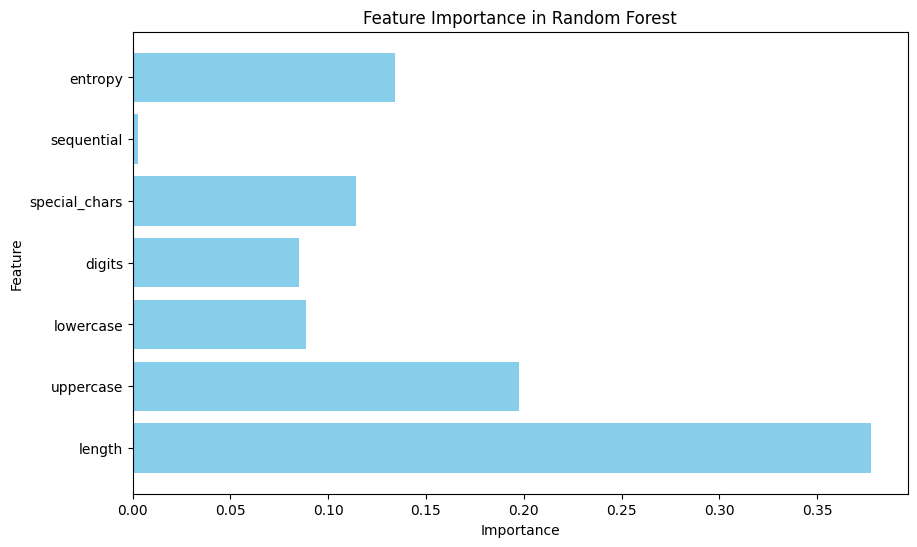

In [10]:
# 1. Feature Importance
feature_importances = rf_model.feature_importances_
features = X.columns

plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest')
plt.show()

Prediction

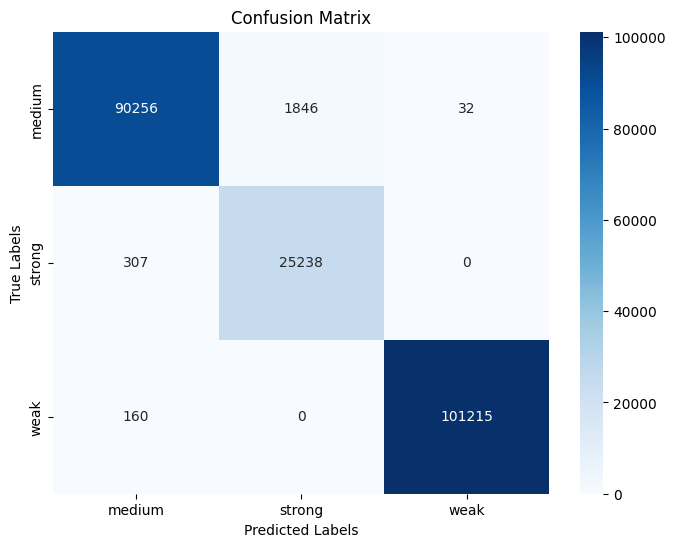

In [11]:
# 2. Confusion Matrix
y_test_pred = rf_model.predict(X_test)
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [12]:
# 3. Classification Report
# y_test_pred = rf_model.predict(X_test)
report = classification_report(y_test, y_test_pred, target_names=label_encoder.classes_)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

      medium       0.99      0.98      0.99     92134
      strong       0.93      0.99      0.96     25545
        weak       1.00      1.00      1.00    101375

    accuracy                           0.99    219054
   macro avg       0.98      0.99      0.98    219054
weighted avg       0.99      0.99      0.99    219054



C:\Users\User\PycharmProjects\PassPy\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


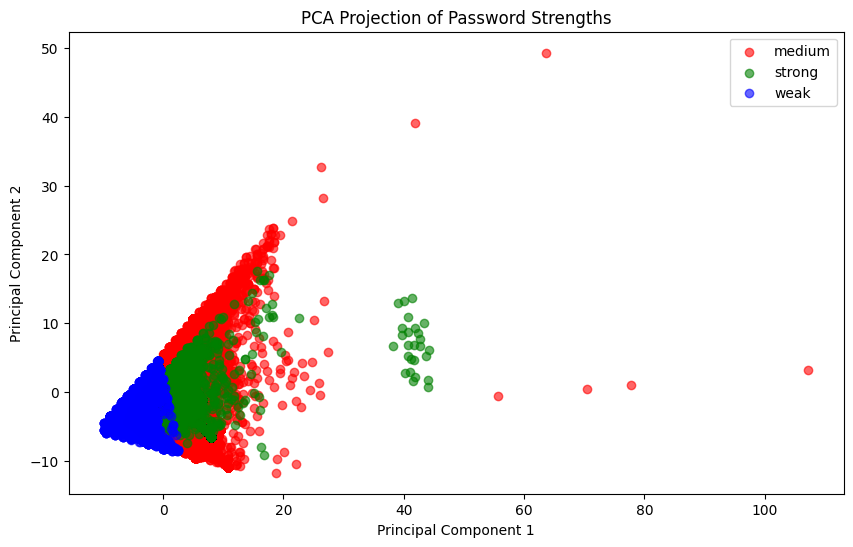

In [13]:
# 4. Feature Pair Visualization (Optional for 2D projection)
from sklearn.decomposition import PCA

# Reduce to 2 dimensions for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

plt.figure(figsize=(10, 6))
colors = ['red', 'green', 'blue']
labels = label_encoder.classes_

for idx, color in enumerate(colors):
    plt.scatter(X_test_pca[y_test == idx, 0], X_test_pca[y_test == idx, 1], c=color, label=labels[idx], alpha=0.6)

plt.title('PCA Projection of Password Strengths')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

In [14]:
# 5. Model Performance
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")


Model Accuracy: 98.93%


In [ ]:
# 6. Parameter Tuning using GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best parameters and accuracy
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

In [ ]:
# Evaluate the model with best parameters
best_rf_model = grid_search.best_estimator_
y_test_best_pred = best_rf_model.predict(X_test)
best_accuracy = accuracy_score(y_test, y_test_best_pred)
print(f"Best Model Accuracy: {best_accuracy * 100:.2f}%")

#### 2.4 KNN model training 

In [17]:
# Standardize the features (important for KNN)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [61]:
type(X_train)

numpy.ndarray

In [18]:
# Train the KNN model (choose K=5 as an example, you can tune this)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [20]:
# Predict on the test set
y_pred_knn = knn.predict(X_test)

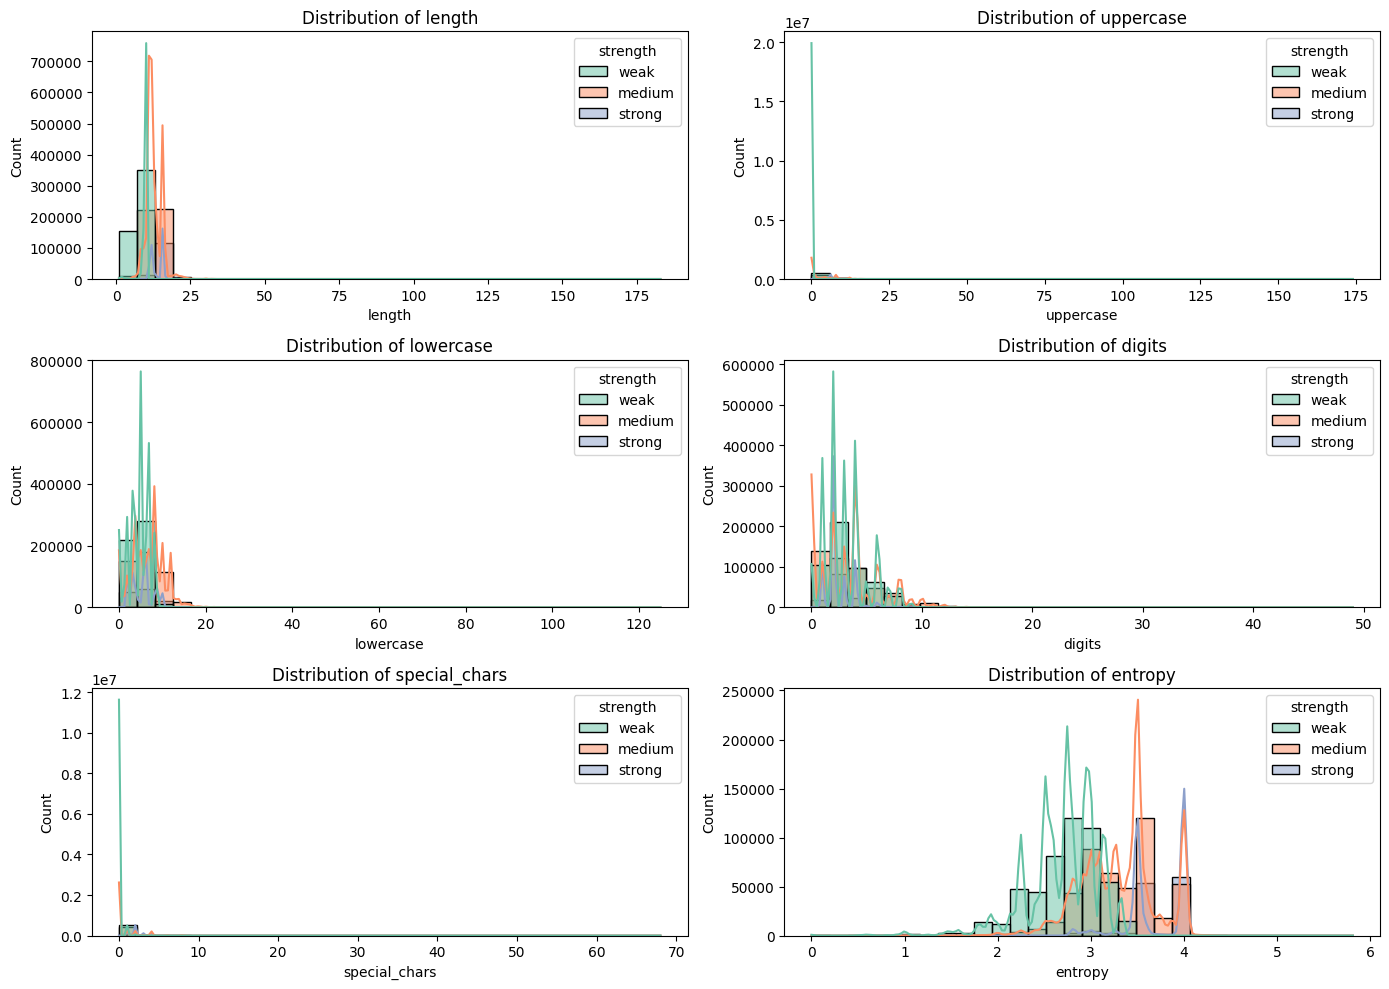

In [21]:
# 1. Feature Distributions
features = ['length', 'uppercase', 'lowercase', 'digits', 'special_chars', 'entropy']
plt.figure(figsize=(14, 10))
for i, feature in enumerate(features):
    plt.subplot(3, 2, i + 1)
    sns.histplot(data=passwords, x=feature, hue='strength', kde=True, palette='Set2', bins=30)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

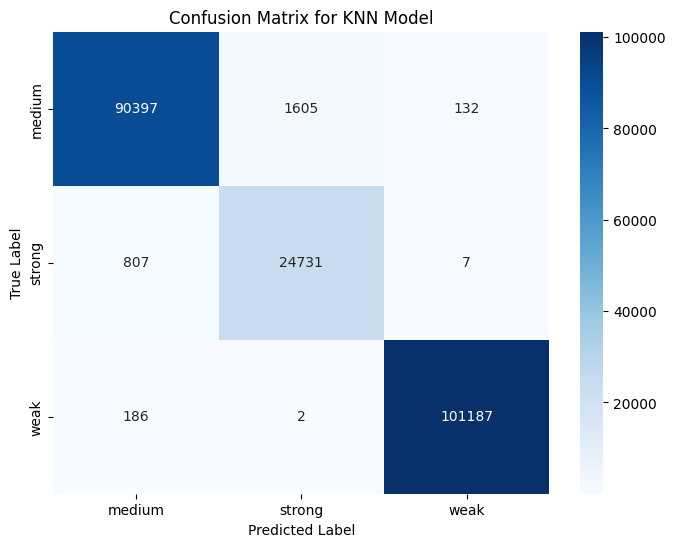

In [22]:
# 2. Confusion Matrix
cm = confusion_matrix(y_test, y_pred_knn)
labels = label_encoder.classes_  # Original strength labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix for KNN Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [23]:
# 3. Classification Report
print("Classification Report:\n")
print(classification_report(y_test, y_pred_knn, target_names=labels))

Classification Report:

              precision    recall  f1-score   support

      medium       0.99      0.98      0.99     92134
      strong       0.94      0.97      0.95     25545
        weak       1.00      1.00      1.00    101375

    accuracy                           0.99    219054
   macro avg       0.98      0.98      0.98    219054
weighted avg       0.99      0.99      0.99    219054



In [25]:
# 4. Feature Importance Approximation (Feature Removal Impact)
accuracy_drop = []
for feature in features:
    X_train_subset = X_train[:, [i for i, f in enumerate(features) if f != feature]]
    X_test_subset = X_test[:, [i for i, f in enumerate(features) if f != feature]]
    
    knn_subset = KNeighborsClassifier(n_neighbors=5)
    knn_subset.fit(X_train_subset, y_train)
    accuracy = knn_subset.score(X_test_subset, y_test)
    accuracy_drop.append(1 - accuracy)

plt.figure(figsize=(10, 6))
sns.barplot(x=features, y=accuracy_drop, palette='viridis')
plt.title('Feature Impact on Model Accuracy')
plt.ylabel('Accuracy Drop After Removal')
plt.xlabel('Feature')
plt.xticks(rotation=45)
plt.show()

KeyboardInterrupt: 

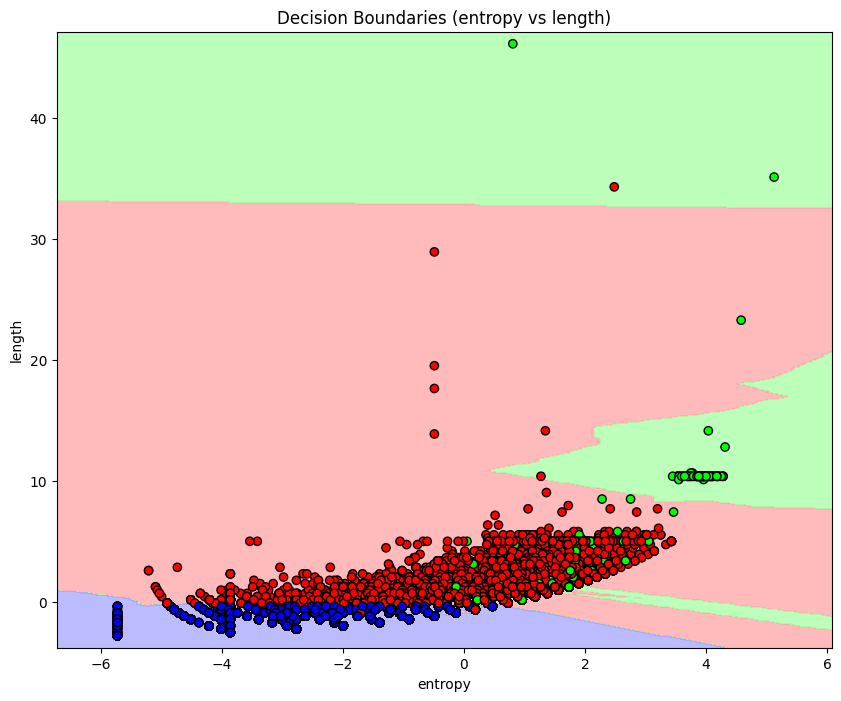

In [26]:
# 5. Decision Boundaries (2D Projection)
from matplotlib.colors import ListedColormap

# Use two features for visualization
feature1, feature2 = 'entropy', 'length'
X_2D = passwords[[feature1, feature2]].values
y_2D = passwords['strength_encoded']

# Train on 2D data
X_train_2D, X_test_2D, y_train_2D, y_test_2D = train_test_split(X_2D, y_2D, test_size=0.2, random_state=42)
scaler_2D = StandardScaler()
X_train_2D = scaler_2D.fit_transform(X_train_2D)
X_test_2D = scaler_2D.transform(X_test_2D)

knn_2D = KNeighborsClassifier(n_neighbors=5)
knn_2D.fit(X_train_2D, y_train_2D)

# Plot decision boundaries
x_min, x_max = X_train_2D[:, 0].min() - 1, X_train_2D[:, 0].max() + 1
y_min, y_max = X_train_2D[:, 1].min() - 1, X_train_2D[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
Z = knn_2D.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.8, cmap=ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF']))
plt.scatter(X_train_2D[:, 0], X_train_2D[:, 1], c=y_train_2D, edgecolor='k', cmap=ListedColormap(['#FF0000', '#00FF00', '#0000FF']))
plt.title(f'Decision Boundaries ({feature1} vs {feature2})')
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.show()


In [1]:
# We display the results
# Evaluate the model
print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))
print("\nKNN Classification Report:\n", classification_report(y_test, y_pred_knn, target_names=label_encoder.classes_))
print("\nKNN Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_knn)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix for KNN')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

NameError: name 'confusion_matrix' is not defined

#### 2.5 Neural network

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Neural Network
mlp_model = MLPClassifier(hidden_layer_sizes=(50, ), max_iter=500, random_state=42)
mlp_model.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, random_state=42)

In [73]:
y_pred_mlp = mlp_model.predict(X_test)

# print("Neural Network Accuracy:", accuracy_score(y_test, y_pred_mlp))
# print("\nNeural Network Classification Report:\n", classification_report(y_test, y_pred_mlp, target_names=label_encoder.classes_))
# print("\nNeural Network Confusion Matrix:\n", confusion_matrix(y_test, y_pred_mlp))

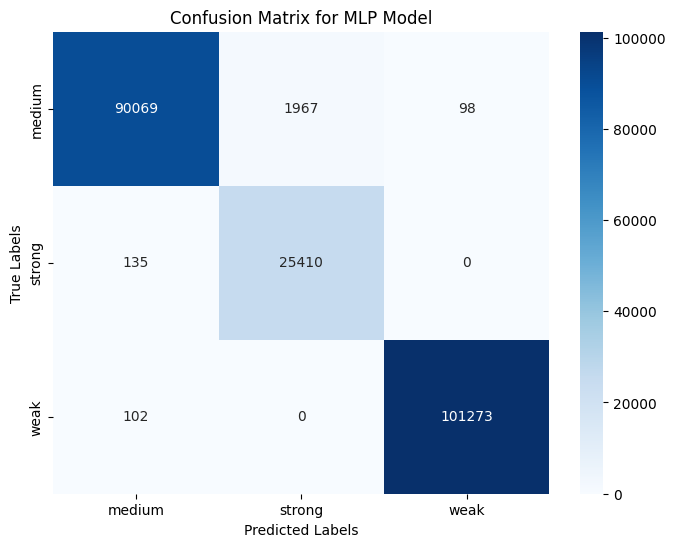

In [74]:
# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred_mlp)
labels = label_encoder.classes_
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix for MLP Model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

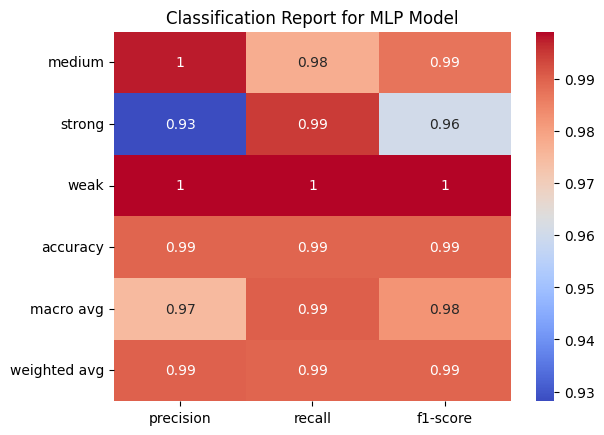

In [75]:
# 2. Classification Report
report = classification_report(y_test, y_pred_mlp, target_names=labels, output_dict=True)
sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap='coolwarm')
plt.title('Classification Report for MLP Model')
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_22364\2806927813.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


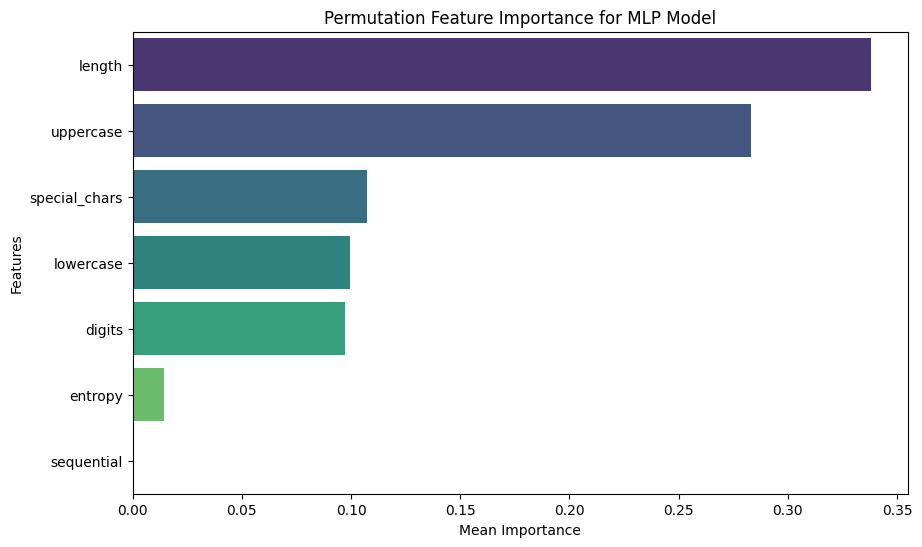

In [76]:
# 3. Permutation Importance (Feature Importance)
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(mlp_model, X_test, y_test, n_repeats=10, random_state=42)
importance_df = pd.DataFrame({'Feature': feature_cols, 'Importance': perm_importance.importances_mean})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Permutation Feature Importance for MLP Model')
plt.xlabel('Mean Importance')
plt.ylabel('Features')
plt.show()

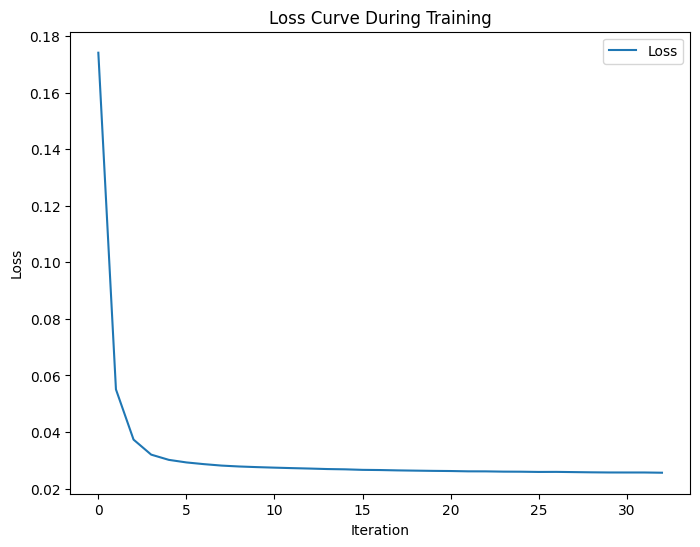

In [77]:
# 4. Loss Curve (if available from MLP)
if hasattr(mlp_model, 'loss_curve_'):
    plt.figure(figsize=(8, 6))
    plt.plot(mlp_model.loss_curve_, label='Loss')
    plt.title('Loss Curve During Training')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


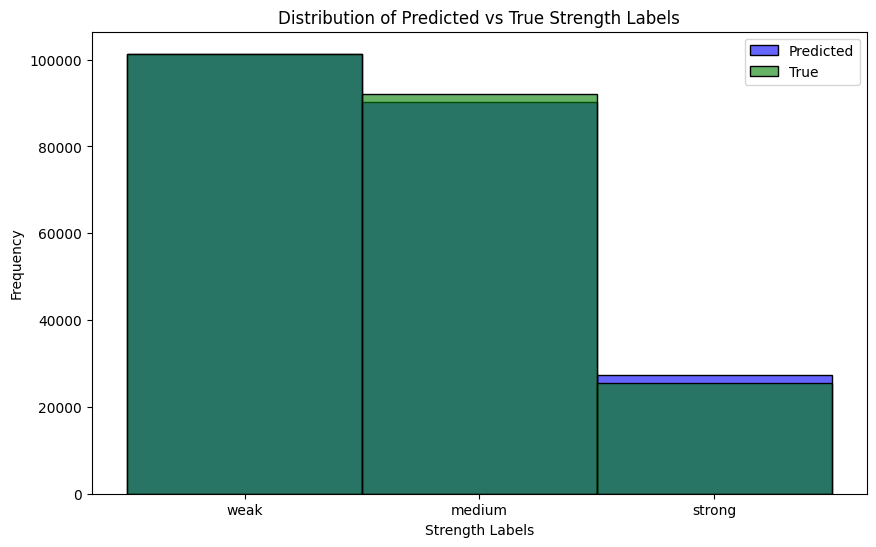

In [78]:
# 5. Distribution of Predictions
predicted_strength = label_encoder.inverse_transform(y_pred_mlp)
true_strength = label_encoder.inverse_transform(y_test)

plt.figure(figsize=(10, 6))
sns.histplot(predicted_strength, label='Predicted', color='blue', alpha=0.6, kde=False)
sns.histplot(true_strength, label='True', color='green', alpha=0.6, kde=False)
plt.title('Distribution of Predicted vs True Strength Labels')
plt.xlabel('Strength Labels')
plt.ylabel('Frequency')
plt.legend()
plt.show()


#### 2.6 Save the models

In [80]:
import joblib
# Save the trained model
joblib.dump(rf_model, 'random_forest_model.pkl')
# Save the Label Encoder
joblib.dump(label_encoder, 'label_encoder.pkl')

# Save the trained MLP model
joblib.dump(mlp_model, 'mlp_model.pkl')
# Save the trained KNN model
joblib.dump(knn, 'knn_model.pkl')

print("Models and Label Encoder saved successfully.")

Models and Label Encoder saved successfully.


#### 2.7. Test the model on passwords

In [7]:
# Load the saved model and label encoder
loaded_model = joblib.load('mlp_model.pkl') # random_forest_model.pkl | mlp_model.pkl | knn_model.pkl
loaded_label_encoder = joblib.load('label_encoder.pkl')

def test_password(password):
    # Extract features
    features = {
        'length': len(password),
        'uppercase': count_uppercase(password),
        'lowercase': count_lowercase(password),
        'digits': count_digits(password),
        'special_chars': count_special_chars(password),
        'sequential': has_sequential_chars(password),
        'entropy': calculate_entropy(password)
    }

    # Convert to a DataFrame with proper feature names
    input_features = pd.DataFrame([features])

    # Predict strength
    predicted_strength = loaded_model.predict(input_features)
    decoded_strength = loaded_label_encoder.inverse_transform(predicted_strength)

    return decoded_strength[0]

# ------------------------------------------Feature extraction functions-------------------
def count_uppercase(password):
    return sum(1 for c in password if c.isupper())

def count_lowercase(password):
    return sum(1 for c in password if c.islower())

def count_digits(password):
    return sum(1 for c in password if c.isdigit())

def count_special_chars(password):
    return sum(1 for c in password if not c.isalnum())

def has_sequential_chars(password):
    # Check for sequences of 3 or more characters
    sequential = False
    for i in range(len(password) - 2):
        substr = password[i:i+3]
        if substr.isalpha() or substr.isdigit():
            if ord(substr[1]) == ord(substr[0]) + 1 and ord(substr[2]) == ord(substr[1]) + 1:
                sequential = True
                break
    return int(sequential)

def calculate_entropy(password):
    # Calculate Shannon entropy
    entropy = 0
    length = len(password)
    if length == 0:
        return 0
    chars = set(password)
    for c in chars:
        p = password.count(c) / length
        entropy -= p * np.log2(p)
    return entropy
#----------------------------------------

In [6]:
# User input
user_password = input("Enter a password to test its strength: ")
strength = test_password(user_password)
print(f"The predicted strength of the password is: {strength}")

Enter a password to test its strength:  oquiouwqr840


The predicted strength of the password is: medium
